In [ ]:
# |default_exp summarization
# |default_cls_lvl 3

In [ ]:
# |hide
%reload_ext autoreload
%autoreload 2

# summarization

Training, saving, and tuning code for building summariztion model(s) that can predict both headlines and short summaries of topics given the text associated to a topic segment

In [ ]:
# |export
from __future__ import annotations

import datetime
import gc
import os
import time
import warnings

import wandb
from blurr.text.data.seq2seq.core import Seq2SeqBatchTokenizeTransform, Seq2SeqTextBlock, default_text_gen_kwargs
from blurr.text.modeling.core import BaseModelCallback, BaseModelWrapper
from blurr.text.modeling.seq2seq.core import Seq2SeqMetricsCallback, blurr_seq2seq_splitter
from blurr.text.utils import get_hf_objects
from blurr.utils import PreCalculatedCrossEntropyLoss
from fastcore.all import *
from fastai.data.block import DataBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.callback.wandb import WandbCallback
from fastai.callback.schedule import *
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, ranger
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers.utils import logging as hf_logging
from transformers import PegasusForConditionalGeneration, BartForConditionalGeneration, T5ForConditionalGeneration

from course_copilot import utils, training, preprocessing

/home/team_007/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Development environment

In [ ]:
# | hide
import pdb

from fastcore.test import *
import nbdev

from blurr.utils import print_versions

In [ ]:
# |export
# silence all the HF warnings
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()

In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.12.1+cu102
fastai: 2.7.9
transformers: 4.22.1


In [ ]:
# |hide
# |cuda
torch.cuda.set_device(1)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #1: Tesla V100-SXM2-16GB


## Setup

In [ ]:
# |export
class SummarizationConfig(training.TrainConfig):
    hf_model_cls = PegasusForConditionalGeneration
    hf_model_checkpoint = "sshleifer/distill-pegasus-cnn-16-4"

    # datablock/dataloaders
    text_gen_kwargs = {}
    tok_kwargs = {}

    # learner
    input_sequence_size = 512
    max_target_length = 10

    batch_size = 8
    use_fp16 = True
    use_wandb = True

In [ ]:
# |export
class ContentSummarizationConfig(SummarizationConfig):
    max_target_length = 80
    text_gen_kwargs = {"do_sample": True, "max_length": 100, "top_k": 50, "top_p": 0.95}

In [ ]:
ContentSummarizationConfig.max_target_length

80

In [ ]:
# |export
class HeadlineSummarizationConfig(SummarizationConfig):
    max_target_length = 5

In [ ]:
class XsumCFG(ContentSummarizationConfig):
    training_subset = 0.25
    n_frozen_epochs = 0
    n_unfrozen_epochs = 1


[f"{k}: {v}" for k, v in training.get_train_config_props(XsumCFG).items()]

['batch_size: 8',
 'hf_model_checkpoint: sshleifer/distill-pegasus-cnn-16-4',
 'hf_model_cls: PegasusForConditionalGeneration',
 'input_sequence_size: 512',
 'max_target_length: 80',
 'n_frozen_epochs: 0',
 'n_unfrozen_epochs: 1',
 'only_seed_splits: True',
 'preprocess_strategy: None',
 'random_seed: 2022',
 "text_gen_kwargs: {'do_sample': True, 'max_length': 100, 'top_k': 50, 'top_p': 0.95}",
 'tok_kwargs: {}',
 'training_subset: 0.25',
 'use_fp16: True',
 'use_wandb: True',
 'val_pct: 0.25']

## Data

In [ ]:
# |export
def _get_training_data(cfg: SummarizationConfig, data_dir="data"):  # configuration for summarization  # data directory
    segmentation_df, summarization_df = preprocessing.preprocess_data(
        ds="train", data_path=data_dir, return_file=True, save_file=False
    )
    return summarization_df

In [ ]:
sdf = _get_training_data(XsumCFG, data_dir="../data")
sdf.head()

,course_title,lesson_num,start_seconds,topic,transcript
0,C-Squared Podcast,1,0,Intro,[Music] welcome everybody to episode one of a chess themed podcast with myself christian kirilla and i'm fighting on caruana so what's up christian well not so much fabi uh it's first of all great um to finally start a podcast the chess podcast i know that um there's a lot of podcasts out there but i wanted to bring our own tune to the mix and i think uh yeah i'm excited about that so that's uh the first thing how about yourself fabian well i'm back in the states after it's been a while at your home it's good to be here it's my first time in uh visiting here and uh yeah it's been an intere...
1,C-Squared Podcast,1,137,Candidates 2018,camps look like in general yeah well you mentioned the 2018 cycle uh where we worked together we started with the training before the candidates and for me it's interesting because i've i've played a lot of these candidates tournaments and i'm always doing it a bit differently trying different things trying to improve it but sometimes it goes less or more successfully you never know what will work out i think what we did in 2018 not just for the candidates but also for the world championship because i qualified for that i think what we did then was extremely successful um we we arranged it...
2,C-Squared Podcast,1,464,Candidates training,going in the candidates like how was the experience yeah i think the preparation was pretty serious it included a bunch of uh camps and preparation devoted to players as i assume i think everyone has the same sort of general approach which is to think about their openings their strategy look at the opponents try to get in shape make sure that you're not you know rusty or blundering things or hallucinating variations uh but there's a lot of nerves and i i felt a lot of nerves before the tournament and i think possibly i you know overworked over trained a bit because it was yeah it was like ...
3,C-Squared Podcast,1,610,Playing for 2nd place,were you just like focused on grabbing first well i was only focused on first but of course there were always these thoughts that well maybe second is enough but you can't play for second like let's say once i had achieved plus three in the tournament and john was plus four and i tried to go and go into like full like risk reverse mode which is still difficult to do but let's say i had gone that mode and and achieved it and like finished second with like plus three and john got plus five uh and then like magnus says well i'm going to play right then you also feel kind of stupid you know li...
4,C-Squared Podcast,1,916,Magnus' WC decision,know you can't uh you can't tell him you have to do something i i guess let me rephrase that fair to let you guys play the tournament first and then tell you the decision well i think he said it in a strange way which was that i'll play against alireza which to me is strange because if you don't want to play world championship match i fully understand you know but did he say that did he actually name him yeah that's kind of what he said um yeah he more he like he didn't say definitively like i won't play against anyone but he was like i probably won't play unless it's frozen right and yeah...


## Huggingface objects

In [ ]:
# | export
def _get_task_hf_objects(cfg: SummarizationConfig):
    hf_tok_kwargs = {}
    if cfg.hf_model_checkpoint == "sshleifer/tiny-mbart":
        hf_tok_kwargs["src_lang"], hf_tok_kwargs["tgt_lang"] = "en_XX", "en_XX"

    hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
        pretrained_model_name_or_path=cfg.hf_model_checkpoint,
        model_cls=cfg.hf_model_cls,
        tokenizer_kwargs=hf_tok_kwargs,
    )
    return hf_arch, hf_config, hf_tokenizer, hf_model

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = _get_task_hf_objects(XsumCFG)
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('pegasus',
 transformers.models.pegasus.configuration_pegasus.PegasusConfig,
 transformers.models.pegasus.tokenization_pegasus_fast.PegasusTokenizerFast,
 transformers.models.pegasus.modeling_pegasus.PegasusForConditionalGeneration)

## Dataloaders

In [ ]:
# |export
def _get_dls(cfg: SummarizationConfig, df, hf_arch, hf_config, hf_tokenizer, hf_model):
    if hf_arch in ["bart", "t5"]:
        cfg.text_gen_kwargs = {**hf_config.task_specific_params["summarization"], **{"max_length": 40, "min_length": 5}}

    # TODO: add text_gen_kwargs dynamically
    generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
    for k in cfg.text_gen_kwargs.copy():
        if k not in generate_func_args:
            del text_gen_kwargs[k]

    if hf_arch == "mbart":
        cfg.text_gen_kwargs["decoder_start_token_id"] = hf_tokenizer.get_vocab()["en_XX"]

    def add_t5_prefix(inp):
        return f"summarize: {inp}" if (hf_arch == "t5") else inp

    batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(
        hf_arch,
        hf_config,
        hf_tokenizer,
        hf_model,
        padding="max_length",
        max_length=cfg.input_sequence_size,
        max_target_length=cfg.max_target_length,
        text_gen_kwargs=cfg.text_gen_kwargs,
    )

    blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)
    dblock = DataBlock(
        blocks=blocks, get_x=ColReader("transcript"), get_y=ColReader("topic"), splitter=RandomSplitter()
    )

    dls = dblock.dataloaders(df, bs=cfg.batch_size)
    return dls

In [ ]:
dls = _get_dls(XsumCFG, sdf, hf_arch, hf_config, hf_tokenizer, hf_model)
b = dls.one_batch()

In [ ]:
len(b), len(b[0]), b[0]["input_ids"].shape, len(b[1]), b[1].shape

(2, 3, torch.Size([8, 512]), 8, torch.Size([8, 80]))

In [ ]:
print(hf_tokenizer.decode(b[0]["input_ids"][0]))

hey everybody we're getting ready to start here everyone's click in on putting my shirt on here oh my dress shirt I was always wearing clothes ok and 3 2 1 boom mics on everything we're ready to go welcome ladies and gentlemen back to my studio here in Vancouver Canada my name is Michael Markowski I'm gonna be showing you how to do some drawing today I'm super excited because I think today we're really going to learn a lot about how to take all these different techniques we've been doing over the past three classes so far put them together to make some new drawings that are gonna really excite us and you're I think you're really gonna be surprised by how much you already know I mean based on just what we've learned so far so we're gonna put it all together and to create some new artworks let me see I'm just gonna turn this light on here okay so let me see what are the little housekeeping things I want to get cleared away right at the beginning if you have any drawings you'd like for me

## Models

In [ ]:
# |export
def _get_learner(cfg: SummarizationConfig, dls, hf_config, hf_model, hf_arch):
    if cfg.random_seed:
        set_seed(cfg.random_seed)

    model = BaseModelWrapper(hf_model)
    learn_cbs = [BaseModelCallback]

    learn = Learner(
        dls,
        model,
        opt_func=ranger,
        loss_func=PreCalculatedCrossEntropyLoss(),
        cbs=learn_cbs,
        splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
    )

    learn.create_opt()
    learn.freeze()

    if cfg.use_fp16:
        learn = learn.to_fp16()

    return learn

In [ ]:
learn = _get_learner(cfg=XsumCFG, dls=dls, hf_config=hf_config, hf_model=hf_model, hf_arch=hf_arch)

SuggestedLRs(minimum=3.311311274956097e-07, steep=9.12010818865383e-07, valley=0.0003311311302240938, slide=4.365158383734524e-05)

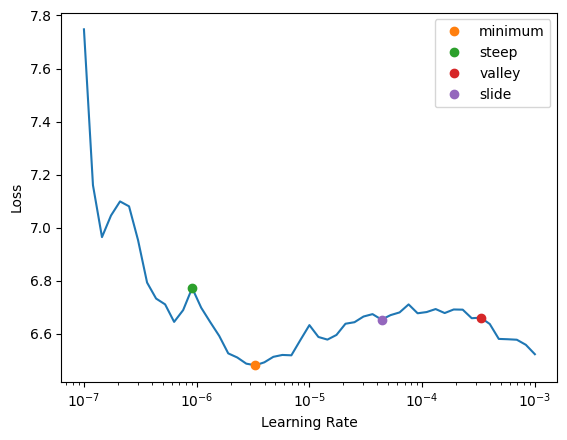

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
seq2seq_metrics = {
    "rouge": {
        "compute_kwargs": {"rouge_types": ["rouge1", "rouge2", "rougeL", "rougeLsum"], "use_stemmer": True},
        "returns": ["rouge1", "rouge2", "rougeL", "rougeLsum"],
    }
}
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

In [ ]:
learn.fit_one_cycle(1, lr_max=5e-4, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,rougeLsum,time
0,5.567179,4.968502,0.147944,0.049079,0.137348,0.138479,01:14


In [ ]:
learn.metrics = None

In [ ]:
export_fname = "summarize_export"
learn.export(fname=f"{export_fname}.pkl")

In [ ]:
del learn, dls, hf_model, hf_tokenizer, hf_config
torch.cuda.empty_cache()
gc.collect()

1347

In [ ]:
learn = load_learner("summarize_export.pkl")

In [ ]:
test_article = """hey everybody welcome back this week we're going to talk about something a little bit different than we do most weeks most weeks we talk about specific
technical aspects of building machine learning powered products but this week we're going to focus on some of the
organizational things that you need to do in order to work together on ml-powered products as part of an
interdisciplinary team so the the reality of building ml Power Products is that building any product well is really
difficult you have to figure out how to hire grade people you need to be able to manage those people and get the best out
of them you need to make sure that your team is all working together towards a shared goal you need to make good
long-term technical choices manage technical debt over time you need to make sure that you're managing
expectations not just of your own team but also of leadership of your organization and you need to be able to make sure
that you're working well within the confines of the requirements of the rest of the org that you're understanding
those requirements well and communicating back to your progress to the rest of the organization against those requirements
but machine learning adds even more additional complexity to this machine learning Talent tends to be very scarce
and expensive to attract machine learning teams are not just a
single role but today they tend to be pretty interdisciplinary which makes managing them an even bigger challenge
machine learning projects often have unclear timelines and there's a high
degree of uncertainty to those timelines machine learning itself is moving super fast and machine learning as we've
covered before you can think of as like the high interest credit card of technical debt so keeping up with making
good long-term decisions and not incurring too much technical debt is especially difficult in ml unlike
traditional software ml is so new that in most organizations leadership tends not to be that well educated in it they
might not understand some of the core differences between ML and other technology that you're working with machine learning products tend to fail
in ways that are really hard for Lay people to understand and so that makes it very difficult to help the rest of
the stakeholders in your organization understand what they could really expect from the technology that you're building
and what is realistic for us to achieve so throughout the rest rest of this lecture we're going to kind of touch on
some of these themes and cover different aspects of this problem of working together to build ml Power Products as
an organization so here are the pieces that we're going to cover we're going to talk about different roles that are involved in building ml products we're
going to talk about some of the unique aspects involved in hiring ml Talent
we're going to talk about organization of teams and how the ml team tends to fit into the rest of the org and some of
the pros and cons of different ways of setting that up we'll talk about managing ml teams and
ml product management and then lastly we'll talk about some of the design considerations for how to design a
product that is well suited to having a good ml model that backs it so let's dive in and talk about rules the most
common ml rules that you might hear of are things like ml product manager ml
"""
learn.blurr_generate(
    test_article, key="summary_texts", do_sample=True, max_length=100, top_k=50, top_p=0.95, num_return_sequences=3
)

[{'summary_texts': ["This week we're going to talk about some of the organizational things that you need to do in order to work together on ml-powered products .",
   "This week we're going to talk about some of the organizational things that you need to do in order to work together on ml-powered products .",
   "This week we're going to talk about some of the organizational things that you need to do in order to work together on ml-powered products ."]}]

In [ ]:
# |export
def _get_preds(model_or_learner, text_data: str, gen_algo, max_length):
    if gen_algo == "greedy":
        return learn.blurr_generate(text_data, key="summary_texts", max_length=max_length)
    elif gen_algo == "topp":
        return learn.blurr_generate(
            text_data,
            key="summary_texts",
            max_length=max_length,
            top_k=50,
            top_p=0.95,
        )
    elif gen_algo == "topk":
        return learn.blurr_generate(text_data, key="summary_texts", max_length=max_length, top_k=50)

In [ ]:
response = _get_preds(learn, test_article, "greedy", 100)
assert isinstance(response[0]["summary_texts"], str)

In [ ]:
_get_preds(learn, test_article, "topp", 15)

[{'summary_texts': "This week we're going to talk about some of the organizational"}]

## Model Trainer

In [ ]:
# |export
class SummarizationModelTrainer(training.ModelTrainer):
    def __init__(
        self,
        experiment_name,
        train_config: SummarizationConfig,
        data_path="data",
        model_output_path="models",
        log_output_path="logs",
        log_preds=False,
        log_n_preds=None,
        use_wandb=False,
        verbose=False,
        **kwargs,
    ):
        super().__init__(
            experiment_name=experiment_name,
            train_config=train_config,
            data_path=data_path,
            model_output_path=model_output_path,
            log_output_path=log_output_path,
            log_preds=log_preds,
            log_n_preds=log_n_preds,
            use_wandb=use_wandb,
            verbose=verbose,
            **kwargs,
        )

    def get_training_data(self):
        return _get_training_data(cfg=self.train_config, data_dir=self.data_path)

    def load_learner_or_model(self, model_learner_fpath: str | Path = None, device="cpu"):
        if model_learner_fpath is None:
            model_learner_fpath = f"{self.model_output_path}/{self.experiment_name}.pkl"

        learn = load_learner(model_learner_fpath, cpu=device == "cpu")
        return learn

## Train

In [ ]:
# | export
@patch
def train(self: SummarizationModelTrainer, sweep_config: dict = None):
    # setup
    start = time.time()

    yyyymmddHm = datetime.today().strftime("%Y%m%d_%H%m")
    seed = self.train_config.random_seed

    # --- step 0: init the WANDB run if logging to wandb and update the training config from the sweep config if doing a sweep
    is_sweep = True if sweep_config is not None else False

    if self.use_wandb:
        run = self.init_wandb_run(is_sweep)

    # --- BEGIN TRAINING ---
    if self.verbose:
        print(f"Experiment: {self.experiment_name}")
        print(f"Training config: f{self.get_train_config_props()}")

    # --- step 1: get our TRAINING DATA ---
    if self.verbose:
        print("Preparing training data ...")

    summarization_df = self.get_training_data()

    # --- step 2: get our HF OBJECTS ---
    if self.verbose:
        print("Building HF objects ...")

    hf_arch, hf_config, hf_tokenizer, hf_model = _get_task_hf_objects(self.train_config)

    # --- step 3: DATALOADERS ---
    if self.verbose:
        print("Building DataLoaders ...")

    dls = _get_dls(self.train_config, summarization_df, hf_arch, hf_config, hf_tokenizer, hf_model)

    # --- step 4: LEARNER ---
    if self.verbose:
        print("Building Learner ...")

    learn = _get_learner(cfg=self.train_config, dls=dls, hf_config=hf_config, hf_model=hf_model, hf_arch=hf_arch)

    seq2seq_metrics = {
        "rouge": {
            "compute_kwargs": {"rouge_types": ["rouge1", "rouge2", "rougeL", "rougeLsum"], "use_stemmer": True},
            "returns": ["rouge1", "rouge2", "rougeL", "rougeLsum"],
        }
    }
    fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

    # add any learner callbacks req. by the `ModelTrainer`
    if self.use_wandb and not is_sweep:
        fit_cbs.append(WandbCallback(log_preds=False))

    if self.train_config.random_seed and not self.train_config.only_seed_splits:
        set_seed(self.train_config.random_seed)

    learn.fit_one_cycle(
        self.train_config.n_unfrozen_epochs,
        cbs=fit_cbs,
        lr_max=1e-4,
    )

    end = time.time()
    if self.verbose:
        print(f"Time took for training is: {end - start}")

    learn.metrics = None

    if self.verbose:
        print("Saving model ...")

    learn.export(self.model_output_path / f"{self.experiment_name}.pkl")

    # clean up
    super(self.__class__, self).train()

    if self.verbose:
        print("End training")

    del learn, dls, hf_model, hf_tokenizer, hf_config
    torch.cuda.empty_cache()
    gc.collect()

    return None

## `get_preds`

In [ ]:
# | export
@patch
def get_preds(self: SummarizationModelTrainer, model_or_learner, data, **kwargs):
    max_length = kwargs.get("max_target_length", 10)
    gen_algo = kwargs.get("gen_algo", "greedy")
    return _get_preds(model_or_learner, data, gen_algo, max_length)

In [ ]:
trainer = SummarizationModelTrainer(
    task="train",
    experiment_name="content_summarization",
    train_config=XsumCFG,
    data_path="../data",
    model_output_path="../models",
    log_output_path="../logs",
    log_preds=True,
    log_n_preds=2,
    use_wandb=True,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hello34. Use `wandb login --relogin` to force relogin


## Example Training code

In [ ]:
trainer.train()

wandb: Currently logged in as: hello34 (course-copilot). Use `wandb login --relogin` to force relogin


Could not gather input dimensions


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,rougeLsum,time
0,6.435354,6.117905,0.094518,0.030334,0.084914,0.086538,01:05


## Example inference code

In [ ]:
inf_learn = trainer.load_learner_or_model("summarize_export.pkl", device="cpu")
predicted_string = trainer.get_preds(inf_learn, test_article)
predicted_string

# cleanup resources
del inf_learn
torch.cuda.empty_cache()
gc.collect()

11533

## Export -

In [ ]:
# |hide
nbdev.nbdev_export()